<a href="https://colab.research.google.com/github/nuyhc/RhythmStudy/blob/main/1.%20PyTorch/PTM_3_%EB%B0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [PTM] 6장. 신경망을 활용한 데이터 적합

In [1]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code

Cloning into 'dlwpt-code'...
remote: Enumerating objects: 703, done.
remote: Total 703 (delta 0), reused 0 (delta 0), pack-reused 703
Receiving objects: 100% (703/703), 176.00 MiB | 19.61 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Checking out files: 100% (228/228), done.


In [2]:
# 데이터 수집
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

print(t_u.shape)
t_c, t_u

torch.Size([11, 1])


(tensor([[ 0.5000],
         [14.0000],
         [15.0000],
         [28.0000],
         [11.0000],
         [ 8.0000],
         [ 3.0000],
         [-4.0000],
         [ 6.0000],
         [13.0000],
         [21.0000]]), tensor([[35.7000],
         [55.9000],
         [58.2000],
         [81.9000],
         [56.3000],
         [48.9000],
         [33.9000],
         [21.8000],
         [48.4000],
         [60.4000],
         [68.4000]]))

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  4,  5,  2, 10,  8,  0,  6,  3]), tensor([9, 7]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

### 파이토치 nn 모듈
forward 대신 __call__ 사용하기
* 파이토치가 제공하는 nn.Module의 모든 서브클래스에는 __call__ 메소드가 정의되어 있다. 이를 통해 nn.Linear를 인스턴스화하여 마치 함수인 것처럼 실행할 수 있다.

nn.Linear
* `nn.Linear`은 세 개의 인자를 갖는다. 입력 피처의 수, 출력 피처의 수, 선형 모델이 편향값을 포함하는지 여부이다.

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)  # 피처 수는 모듈에 대한 입출력 텐서 크기와 같아서, 값이 각각 1, 1이다.
linear_model(t_un_val)

tensor([[6.0219],
        [2.5925]], grad_fn=<AddmmBackward0>)

하나의 입력 피처와 출력 피처를 가진 nn.Linear 인스턴스
* 이 인스턴스는 weight와 bias값을 요구한다.

In [6]:
display(linear_model.weight)
linear_model.bias

Parameter containing:
tensor([[0.8884]], requires_grad=True)

Parameter containing:
tensor([0.6557], requires_grad=True)

In [7]:
# 입력값으로 모듈 호출
x = torch.ones(1)
linear_model(x)

tensor([1.5442], grad_fn=<AddBackward0>)

### 배치 입력 만들기
nn에 있는 모든 모듈은 한 번에 여러 입력을 가진 batch에 대한 출력을 만들도록 작성되었다. 
  
[아래 코드]
* 10개의 샘플에 대해 nn.Linear을 실행해야 한다고 가정해보자. B가 배치의 크기이고, Nin이 입력 피처의 크기라면 크기가 B X Nin인 입력 텐서를 만들고 모델로 실행하는 이다.

In [8]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442],
        [1.5442]], grad_fn=<AddmmBackward0>)

### 배치 최적화
배치를 수행하는 이유
* 주요 이유 중 하나는 연산량을 충분히 크게 만들어 준비한 자원을 최대한 활용하기 위함이다.

In [9]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

학습 코드 업데이트
* 작성한 모델을 nn.Linear(1, 1)로 바꾼 후 옵티마이저에 선형 모델 파라미터 전달

In [10]:
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),  # [params] 대신 넣은 것  
    lr = 1e-2
)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7f096e74d7b0>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.5645]], requires_grad=True), Parameter containing:
 tensor([-0.3435], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training Loss {loss_train.item():.4f},',
                  f'Validation Loss {loss_val.item():.4f}')

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),  # 이제 직접 만든 손실 함수는 사용하지 않는다.
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training Loss 351.1638, Validation Loss 163.3999
Epoch 1000, Training Loss 4.8112, Validation Loss 2.7622
Epoch 2000, Training Loss 2.7206, Validation Loss 4.0367
Epoch 3000, Training Loss 2.5473, Validation Loss 5.7075

Parameter containing:
tensor([[5.6421]], requires_grad=True)
Parameter containing:
tensor([-18.7034], requires_grad=True)


### 신경망
선형 모델 대신 신경망을 근사 함수로 사용하도록 바꿔보자

* nn은 nn.Sequential 컨테이너를 통해 모듈을 간단하게 결합시켜준다.  

아래 모델은 한 개의 입력 피처로부터 13개의 은닉된 피처로 펼쳐지며, 결과값을 tanh 활성 함수로 넘겨서 결과로 나운 13개의 숫자를 하나의 출력 피처로 만들기 위해 선형적으로 결합한다. 

In [15]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

파라미터 살펴보기

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

여러 개의 서브 모듈로 만들어진 모델의 파라미터를 추적할 경우, 파라미터를 이름으로 식별가능하게 하면 매우 편리하다.

In [17]:
# named_parameters
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Sequential은 OrderedDict라는 인자를 받는데, 여기에 각 모듈의 이름을 정해서 전달할 수 있다.

In [18]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([  # 연속적인 경로를 만들어낸다는 점에서 Sequential이라는 이름이 매우 적절함
            ('hidden_linear', nn.Linear(1, 8)),
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param)

hidden_linear.weight Parameter containing:
tensor([[-0.9920],
        [ 0.8089],
        [-0.6840],
        [-0.3758],
        [-0.1620],
        [-0.9197],
        [-0.1052],
        [ 0.7612]], requires_grad=True)
hidden_linear.bias Parameter containing:
tensor([-0.6096, -0.9763,  0.8998, -0.0048,  0.7788,  0.0944,  0.6939, -0.9531],
       requires_grad=True)
output_linear.weight Parameter containing:
tensor([[ 1.2276e-01,  1.5866e-01,  6.3646e-02, -1.1953e-04, -1.4939e-01,
          3.0586e-01, -7.2619e-04,  1.9996e-01]], requires_grad=True)
output_linear.bias Parameter containing:
tensor([0.3418], requires_grad=True)


In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


서브 모듈을 속성처럼 사용해 특정 Parameter에 접근할 수 있다.

In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.3418], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 202.7606, Validation Loss 89.6794
Epoch 1000, Training Loss 11.5623, Validation Loss 0.1661
Epoch 2000, Training Loss 3.5077, Validation Loss 2.8277
Epoch 3000, Training Loss 1.8590, Validation Loss 6.4987
Epoch 4000, Training Loss 1.4462, Validation Loss 8.9832
Epoch 5000, Training Loss 1.4088, Validation Loss 9.8235
output tensor([[15.8817],
        [-0.6318]], grad_fn=<AddmmBackward0>)
answer tensor([[13.],
        [-4.]])
hidden tensor([[ 0.0014],
        [-0.0247],
        [ 0.0037],
        [ 0.0428],
        [-0.0014],
        [ 0.0072],
        [-0.0111],
        [ 0.0038]])


### 선형 모델과 비교하기

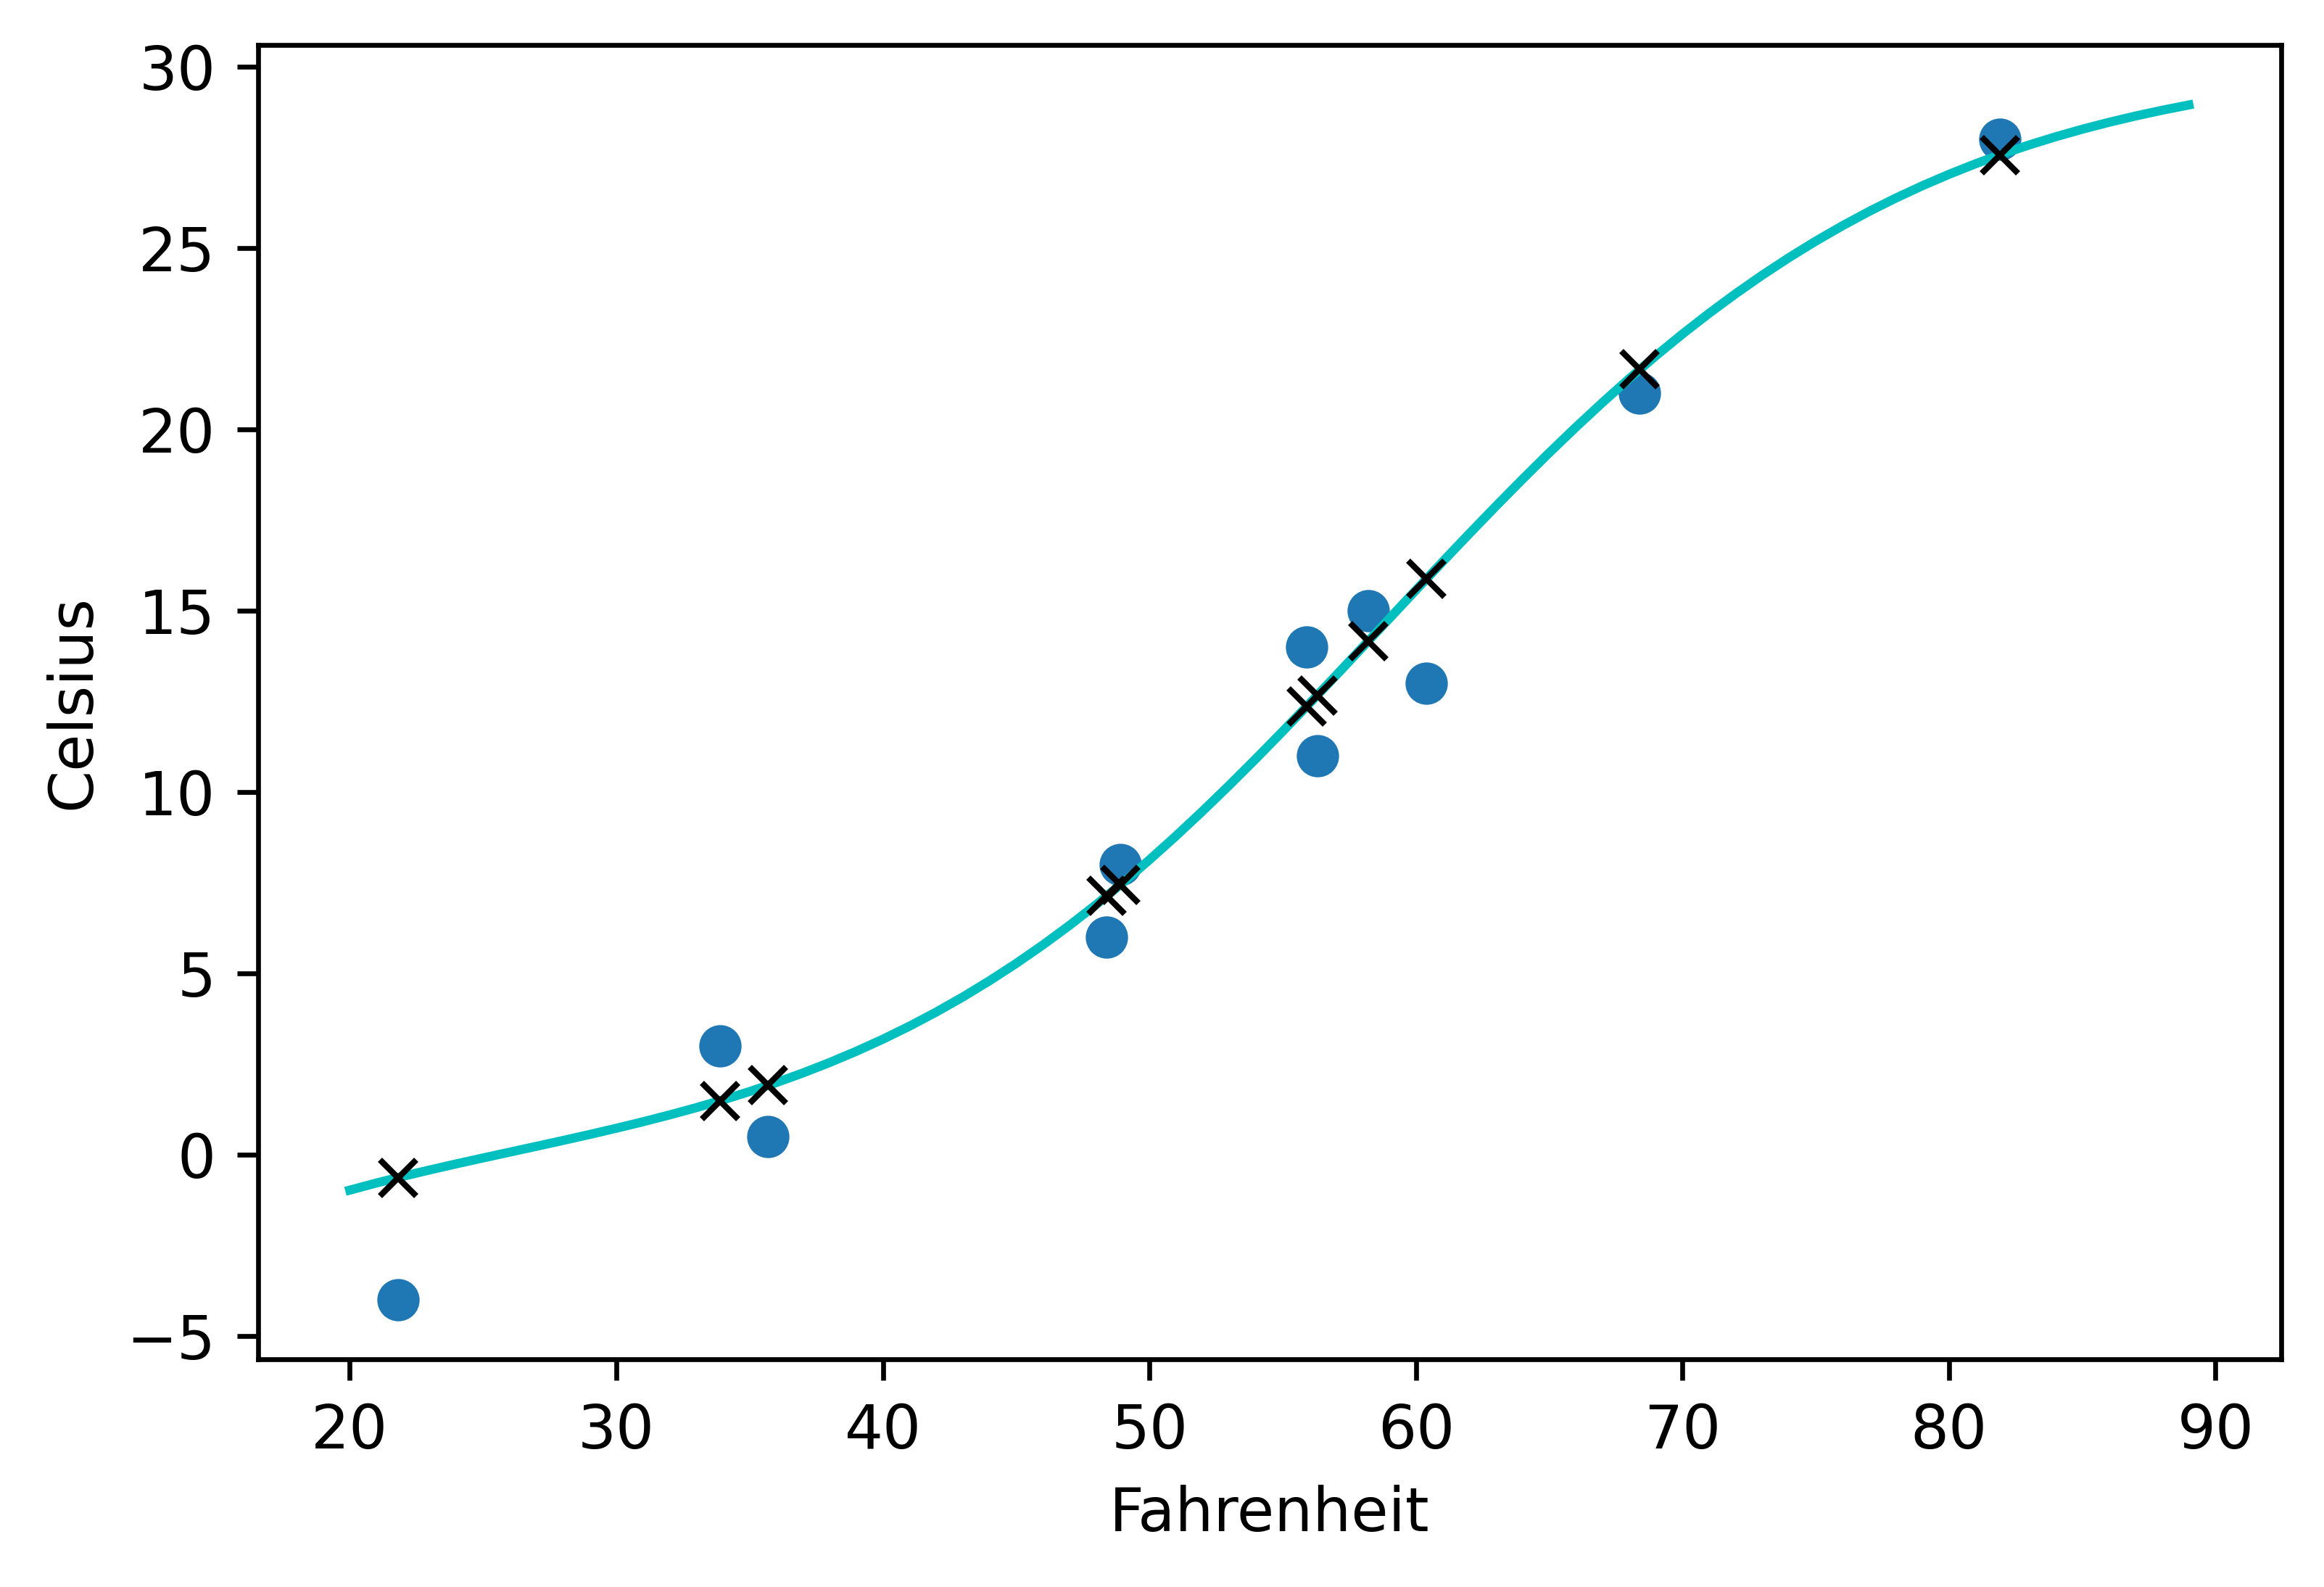

In [23]:
import matplotlib.pyplot as plt

t_range = torch.arange(20. , 90. ).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')  # 입력 데이터
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(),'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')  # 신경망 모델 그래프

plt.show()

# [PTM] 7장. 새와 비행기 구별하기: 이미지 학습

CIFAR-10 다운로드
* 32 x 32 크기의 컬러(RGB) 이미지 6만 개로 구성되어 있고 1에서 10까지의 정수로 레이블이 매겨져 있다. 0은 비행기, 1은 자동차, 2는 새, 3은 고양이, 4는 사슴, 5는 강아지, 6은 개구리. 7은 말, 8은 배, 9는 트럭이다.

In [24]:
from torchvision import datasets
data_path = '/content/dlwpt-code/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/dlwpt-code/p1ch7/cifar-10-python.tar.gz to /content/dlwpt-code/p1ch7
Files already downloaded and verified


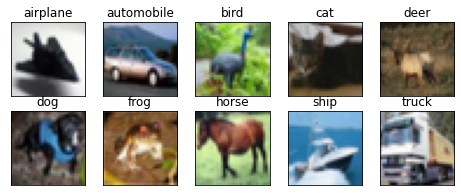

In [25]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

데이터셋은 `torch.utils.data.dataset.Dataset`의 서브클래스로 반환된다. cifar10 인스턴스의 메소드를 분석해보면 기본 클래스로 포함된 것을 알 수 있다.

In [26]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

파이토치 Dataset 객체 개념: 데이터를 직접 들고 있지는 않지만 `__len__`과 `__getitem__`을 통해 일관적으로 접근할 수 있게 해준다.

In [27]:
display(cifar10.__len__)
len(cifar10)

<bound method CIFAR10.__len__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train>

50000

In [28]:
display(cifar10.__getitem__)
cifar10[4]

<bound method CIFAR10.__getitem__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train>

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F09E7D7D190>, 1)

### 데이터셋 클래스

In [29]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F09E7D7D340>,
 1,
 'automobile')

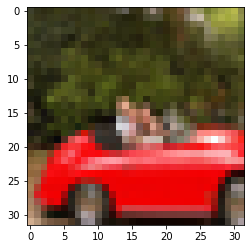

In [30]:
plt.imshow(img)
plt.show()

### 데이터 변환

In [31]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

torchvision의 transforms에서 ToTensor 메서드로 넘파이 배열, 이미지를 텐서로 만들기

In [32]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

transforms에서 ToTensor 메서드로 변환 자체를 dataset.CIFAR10의 인자로 전달하기 

In [33]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
tensor_cifar10

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [35]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

원본 `PIL 이미지` 값은 `0에서 255(채널당 8비트)` 범위인 반면 `ToTensor 변환`으로 데이터가 `채널당 32비트 부동소수점 형태`가 되면서 값이 `0.0`에서 `1.0` 사이로 범위가 줄어든다.

In [36]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

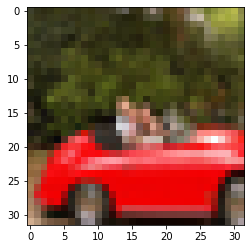

In [37]:
# matplotlib에서는 permute로 H X W X C 형태로 바꿈
plt.imshow(img_t.permute(1, 2, 0))  # C X H X W를 H X W X C로 바꿔준다.
plt.show()

### 데이터 정규화

데이터셋 정규화로 각 채널이 평균값 0과 단위 표준 편차를 만드는 연습을 해보자.  
평균값 0과 단위 표준 편차가 필요한 이유
* -1, 1 혹은 -2, 2 사이에서 선형인 활성 함수를 택하고 데이터를 같은 범위에서 평균을 가지게 된다면 뉴런은 0이 아닌 기울기를 가지게 되므로 빨리 학습할 수 있다.
* 각 채널을 정규화해 동일한 분산을 가지게 된다면 채널 정보가 동일한 학습률로 경사 하강을 통해 섞이고 업데이트되는 것을 보장할 수 있다.


In [38]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [39]:
imgs[0]

tensor([[[0.2314, 0.6039, 1.0000,  ..., 0.1373, 0.7412, 0.8980],
         [0.1686, 0.4941, 0.9922,  ..., 0.1569, 0.7294, 0.9255],
         [0.1961, 0.4118, 0.9922,  ..., 0.1647, 0.7255, 0.9176],
         ...,
         [0.6196, 0.3569, 0.9922,  ..., 0.3882, 0.6863, 0.8510],
         [0.5961, 0.3412, 0.9922,  ..., 0.3098, 0.6745, 0.8667],
         [0.5804, 0.3098, 0.9922,  ..., 0.3490, 0.6627, 0.8706]],

        [[0.0627, 0.5490, 1.0000,  ..., 0.2235, 0.7608, 0.8706],
         [0.0000, 0.5686, 1.0000,  ..., 0.1725, 0.7490, 0.9373],
         [0.0706, 0.4902, 1.0000,  ..., 0.1961, 0.7451, 0.9137],
         ...,
         [0.4824, 0.3765, 1.0000,  ..., 0.6118, 0.6784, 0.8745],
         [0.4667, 0.3020, 1.0000,  ..., 0.5529, 0.6706, 0.8902],
         [0.4784, 0.2784, 1.0000,  ..., 0.4549, 0.6549, 0.8235]],

        [[0.0980, 0.5490, 1.0000,  ..., 0.3843, 0.8157, 0.8353],
         [0.0627, 0.5451, 0.9961,  ..., 0.2510, 0.8039, 0.9176],
         [0.1922, 0.4510, 0.9961,  ..., 0.2706, 0.8000, 0.

view(3, -1)
* view(3, -1)은 세 채널은 유지하고 나머지 차원을 적절한 크기 하나로 합친다. 그래서 `3 X 32 X 32 이미지`는 `3 X 1,024 벡터`로 바뀌고 평균은 각 채널의 1,024개 요소에 대해 계산하는 것이다.

In [40]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [41]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [42]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [43]:
transforms_cifar10 = datasets.CIFAR10(
                     data_path, train = True, download = True,
                     transform = transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                              (0.2470, 0.2435, 0.2616))
                     ]))

Files already downloaded and verified


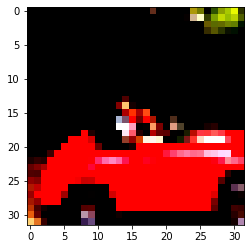

tensor([[[-1.0051, -1.1956, -1.2591,  ...,  0.6620,  0.9160,  0.1856],
         [-0.9892, -1.1163, -1.1639,  ...,  0.5984,  0.7255,  0.3127],
         [-1.0686, -0.9734, -1.1004,  ...,  0.4397,  0.3920, -0.0366],
         ...,
         [ 0.7413,  0.2809,  0.0745,  ..., -0.4971,  0.2492,  0.2174],
         [ 0.9160,  0.3920, -0.7193,  ..., -0.7035,  0.1539,  0.2809],
         [ 1.3288,  0.9001,  0.2174,  ..., -1.0527,  0.0745,  0.6937]],

        [[-0.9496, -1.1750, -1.2717,  ...,  0.7898,  0.9830,  0.2100],
         [-0.9335, -1.1267, -1.1750,  ...,  0.7415,  0.8220,  0.3710],
         [-0.9818, -0.9174, -1.0140,  ...,  0.5160,  0.4999,  0.0812],
         ...,
         [ 0.1939, -0.2087, -1.0784,  ..., -0.7724, -0.2409, -0.2893],
         [ 0.3710, -0.0799, -0.9496,  ..., -0.8207, -0.0799,  0.0328],
         [ 0.8220,  0.4516, -0.2248,  ..., -1.1106, -0.0638,  0.5321]],

        [[-1.0472, -1.3170, -1.4220,  ..., -0.6724, -0.5675, -0.6275],
         [-1.1521, -1.3170, -1.3021,  ..., -0

In [44]:
img_t, _ = transforms_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

img_t

### 새와 비행기 구별하기